In [2]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [5]:
import re
from random import shuffle
from glob import glob

In [23]:
IMG_SIZE = (224, 224)

In [54]:
# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    #return preprocess_input(array)  # предобработка для VGG16
    return array  # предобработка для VGG16

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [3]:
#функция аугментации
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

In [44]:
train_dir = 'd:/ml/catsdogs/train'
validate_dir = 'd:/ml/catsdogs/val'

In [51]:
test_files = glob('d:/ml/catsdogs/test/*.jpg')

In [46]:
#кол-во изображений train
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

20000


In [47]:
#кол-во изображений validate
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

5000


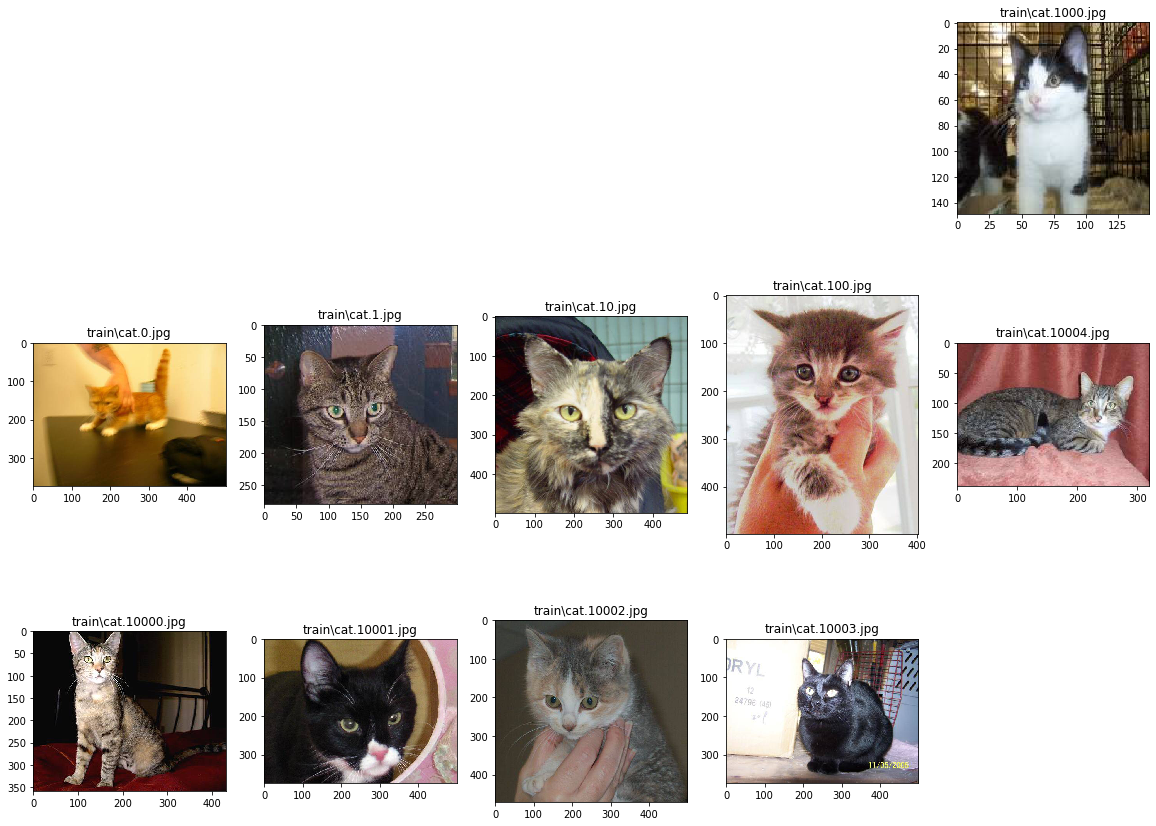

In [8]:
#посмотрим на датасет
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

In [9]:
#проверим, как работает аугментация

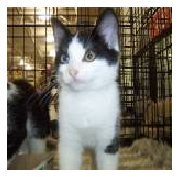

In [11]:
aug_test_img = load_img(train_files[4])
plt.figure(figsize = (3,3))
plt.imshow(aug_test_img)
plt.axis('off')
plt.show()

In [15]:
aug_test_array = img_to_array(aug_test_img)
aug_test_array_r = aug_test_array.reshape((1,) + aug_test_array.shape)

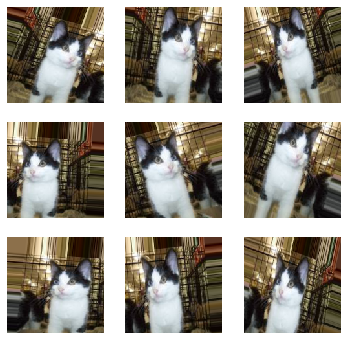

In [22]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(aug_test_array_r, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(aug_test_array.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

In [24]:
# предобработка данных для train
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [25]:
# предобработка данных для validate
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [31]:
# генерация тренировочных данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (IMG_SIZE[0], IMG_SIZE[1]),
    batch_size = 1)

Found 20000 images belonging to 2 classes.


In [33]:
# генерация валидационных данных
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (IMG_SIZE[0], IMG_SIZE[1]),
    batch_size = 1)

Found 5000 images belonging to 2 classes.


In [143]:
# берем предобученную модель VGG16
vgg16_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [144]:
# фиксируем все веса предобученной сети
for layer in vgg16_model.layers:
    layer.trainable = False

In [145]:
# слой для классификации на основе softmax
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

In [146]:
model = Model(input = vgg16_model.input, output = predictions)

C:\Users\costa\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [148]:
# компилируем
model.compile(optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [162]:
# обучаем с использованием аугментации
transfer_learning_history = model.fit_generator(
    train_generator,
    epochs = 10,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')

Epoch 1/10
   10/20000 [..............................] - ETA: 4:44 - loss: 0.4822 - acc: 0.7000

C:\Users\costa\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
C:\Users\costa\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, validation_data=<keras_pre..., class_weight="auto", steps_per_epoch=20000, validation_steps=5000)`
  if __name__ == '__main__':


20000/20000 [==============================] - 271s 14ms/step - loss: 0.2961 - acc: 0.8692 - val_loss: 0.2436 - val_acc: 0.8926
Epoch 2/10
20000/20000 [==============================] - 260s 13ms/step - loss: 0.2630 - acc: 0.8840 - val_loss: 0.2471 - val_acc: 0.8882
Epoch 3/10
20000/20000 [==============================] - 257s 13ms/step - loss: 0.2418 - acc: 0.8960 - val_loss: 0.2345 - val_acc: 0.9060
Epoch 4/10
20000/20000 [==============================] - 258s 13ms/step - loss: 0.2373 - acc: 0.8954 - val_loss: 0.2114 - val_acc: 0.9078
Epoch 5/10
20000/20000 [==============================] - 262s 13ms/step - loss: 0.2300 - acc: 0.9013 - val_loss: 0.2228 - val_acc: 0.9022
Epoch 6/10
20000/20000 [==============================] - 262s 13ms/step - loss: 0.2290 - acc: 0.9015 - val_loss: 0.2245 - val_acc: 0.9026
Epoch 7/10
20000/20000 [==============================] - 263s 13ms/step - loss: 0.2297 - acc: 0.9021 - val_loss: 0.2239 - val_acc: 0.9042
Epoch 8/10
20000/20000 [==============

In [163]:
# смотрим метрики
score = model.evaluate_generator(validate_generator, nb_validate_samples)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2867642112325404
Test Accuracy: 0.8812


In [164]:
model.save('cats-dogs-vgg16_3.hdf5')

In [165]:
# предсказываем классы для тестовых данных
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [166]:
pred

array([[0.000000e+00, 1.000000e+00],
       [1.000000e+00, 0.000000e+00],
       [7.247958e-24, 1.000000e+00],
       ...,
       [0.000000e+00, 1.000000e+00],
       [1.000000e+00, 0.000000e+00],
       [0.000000e+00, 1.000000e+00]], dtype=float32)

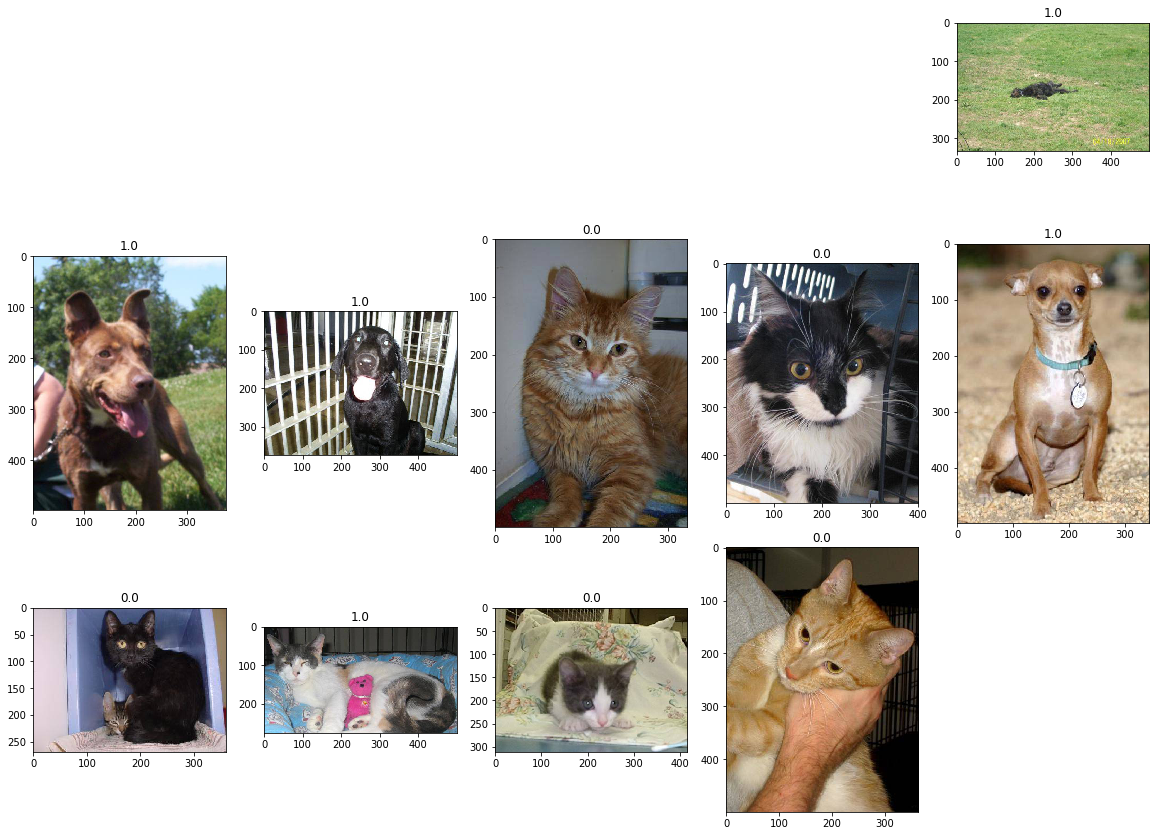

In [167]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title(score[1]);

In [168]:
res = {}

for path, score in zip(test_files, pred):
    key = int(re.search('(\d+)', path).group(0))
    res[key] = round(np.clip(score[1],0.0125,0.9875),5)

In [169]:
with open('submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for x in sorted(res):
        dst.write('%s,%.5f\n' % (x, res[x]))

In [170]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission.csv -m "4st submit"

Successfully submitted to Dogs vs. Cats Redux: Kernels Edition



  0%|          | 0.00/172k [00:00<?, ?B/s]
  5%|4         | 8.00k/172k [00:00<00:03, 51.6kB/s]
 70%|######9   | 120k/172k [00:00<00:00, 71.7kB/s] 
100%|##########| 172k/172k [00:05<00:00, 35.1kB/s]
